# Grid Problem and Node

In [1]:

import random
from IPython.display import HTML
from matplotlib import lines
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np

# we need to define new node and problem objects to deal with this
# non-graph problems

class Problem:
    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2. If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self, state):
        """For optimization problems, each state has a value. Hill Climbing
        and related algorithms try to maximize this value."""
        raise NotImplementedError


# ______________________________________________________________________________


class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
        return next_node

    def solution(self):
        return [node.action for node in self.path()[1:]]

    def path(self):
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        return hash(self.state)


# Animation Algorithm

The search algorithms supported are BFS/DFS/A-star/Dijkstra. They all are implemented by using lambda function that determines how to expand the nodes in traversing. 

It is very interesting to see how we can abstract the whole algorithm to just a function with a signle input and output.
So for example in BFS, you expand the node that is the closest to the source.
In DFS, you expand the node that is closest to the destination. (the exact opposite to bfs).


**Don't** waste so much time understand the following code, except ```self.SOLVERS``` in ```class AnimateProblem``` constructor as you will see what I said above about abstracting the algorithm in just a one-liner. 

In [4]:
def plot_grid_problem(grid, solution, reached=(), title='Search', show=True):
    "Use matplotlib to plot the grid, obstacles, solution, and reached."
    reached = list(reached)
    plt.figure(figsize=(16, 10))
    plt.axis('off'); plt.axis('equal')
    plt.scatter(*transpose(grid.obstacles), marker='s', color='darkgrey')
    plt.scatter(*transpose(reached), 1**2, marker='.', c='blue')
    plt.scatter(*transpose(path_states(solution)), marker='s', c='blue')
    plt.scatter(*transpose([grid.initial]), 9**2, marker='D', c='green')
    plt.scatter(*transpose([grid.goal]), 9**2, marker='8', c='red')
    if show: plt.show()
    print('{} {} search: {:.1f} path cost, {:,d} states reached'
          .format(' ' * 10, title, solution.path_cost, len(reached)))
    
def plots(grid, weights=(1.4, 2)): 
    """Plot the results of 4 heuristic search algorithms for this grid."""
    solution = astar_search(grid)
    plot_grid_problem(grid, solution, reached, 'A* search')
    for weight in weights:
        solution = weighted_astar_search(grid, weight=weight)
        plot_grid_problem(grid, solution, reached, '(b) Weighted ({}) A* search'.format(weight))
    solution = greedy_bfs(grid)
    plot_grid_problem(grid, solution, reached, 'Greedy best-first search')

    
def transpose(matrix): return list(zip(*matrix))

def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

def random_lines(X=range(15, 130), Y=range(60), N=150, lengths=range(6, 12)):
    """The set of cells in N random lines of the given lengths."""
    result = set()
    for _ in range(N):
        x, y = random.choice(X), random.choice(Y)
        dx, dy = random.choice(((0, 1), (1, 0)))
        result |= line(x, y, dx, dy, random.choice(lengths))
    return result

def line(x, y, dx, dy, length):
    """A line of `length` cells starting at (x, y) and going in (dx, dy) direction."""
    return {(x + i * dx, y + i * dy) for i in range(length)}


class AnimateProblem(Problem):
    directions = [(-1, -1), (0, -1), (1, -1),
                  (-1, 0),           (1,  0),
                  (-1, +1), (0, +1), (1, +1)]

    def __init__(self, solver, weight=1.4, # this is the weight of one step
                 height=20, width=40, cell_weights=None,
                 initial=(1, 1), goal=(35, 19),
                 obstacles=random_lines(X=range(40), Y=range(20), N=80, lengths=range(1, 7))):
        """Animate the Grid Problem"""
        self.height = height
        self.width = width
        self.initial = initial
        self.goal = goal
        self.obstacles = set(obstacles) - {self.initial, self.goal}
        self.weight = weight
        # We may change the cell_weights in case of Uniform Cost search
        self.cell_weights = cell_weights
        if self.cell_weights is None:
            self.cell_weights = np.ones((self.width+5, self.height+5), dtype=np.int16)
        # Define all the allowed solvers and their f-value function.
        self.SOLVERS = {'astar': (lambda n: n.path_cost + self.h(n)),
                        'bfs': (lambda n: n.depth),
                        'dfs': (lambda n: -n.depth),
                        'dijkstra': (lambda n: n.path_cost)
                       }
        self.solver_f = self.SOLVERS[solver] # Assign the solver's f-value function
        self.solver = solver
        self.__initial_node = Node(self.initial)
        # Dictionary of reach nodes. Simlar to `explored` set.
        self.reached = {self.initial: self.__initial_node}
        # Frontier of nodes to be explored!
        self.frontier = list()
        self.frontier.append(self.__initial_node)
        # We will draw each frame onto this figure
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        self.solution = [(-1, -1)]
        self.ax.axis('off')
        self.ax.axis('equal')
        self.done = False
    
    def h(self, node): return straight_line_distance(node.state, self.goal)

    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        return action if action not in self.obstacles else state
    
    def draw_walls(self):
        self.obstacles |= {(i, -2) for i in range(-2, self.width+4)}
        self.obstacles |= {(i, self.height+4) for i in range(-2, self.width+4)}
        self.obstacles |= {(-2, j) for j in range(-2, self.height+5)}
        self.obstacles |= {(self.width+4, j) for j in range(-2, self.height+5)}

    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        return {(x + dx, y + dy) for (dx, dy) in self.directions} - self.obstacles
    
    def path_cost(self, c, state1, action, state2):
        """Return the cost of moving from s to s1"""
        return c + self.cell_weights[state2[0]][state2[1]]
        
    def step(self, frame):
        """
        One step of search algorithm.
        """
        # If we are done, don't do anything.
        if self.done:
            return self.sc1, self.sc2, self.sc3, self.sc4, self.sc5, self.sc6
        
        # Run the search algorithm for a single
        # node in the frontier.
        node = min(self.frontier, key = lambda node : self.solver_f(node))
        self.frontier.remove(node)
        self.solution = node.solution()
        if self.goal_test(node.state):
            self.done = True
        else:
            for child in node.expand(self):
                s = child.state
                if s not in self.reached or child.path_cost < self.reached[s].path_cost:
                    self.reached[s] = child
                    self.frontier.append(child)

        self.ax.clear()
        self.ax.axis('off')
        self.ax.axis('equal')
        self.sc1 = self.ax.scatter(*transpose(self.obstacles), marker='s', color='darkgrey')
        self.sc2 = self.ax.scatter(*transpose(list(self.reached)), 1**2, marker='.', c='blue')
        self.sc3 = self.ax.scatter(*transpose(self.solution), marker='s', c='blue')
        self.sc4 = self.ax.scatter(*transpose([node.state]), 9**2, marker='8', c='yellow')
        self.sc5 = self.ax.scatter(*transpose([self.initial]), 9**2, marker='D', c='green')
        self.sc6 = self.ax.scatter(*transpose([self.goal]), 9**2, marker='8', c='red')
        plt.title("Explored: {}, Path Cost: {}\nSolver: {}".format(len(self.reached), node.path_cost, self.solver))
        return self.sc1, self.sc2, self.sc3, self.sc4, self.sc5, self.sc6
        
    
    def run(self, frames=200):
        """
        Run the main loop of the problem to
        create an animation. If you are running
        on your local machine, you can save animations
        in you system by using the following commands:
        First, you need to download the ffmpeg using:
        Linux/MacOS: `sudo apt install ffmpeg`
        Then you can use the following line of code to generate
        a video of the animation.
        Linux/MacOS : `anim.save('animation.mp4')`
        For Windows users, the process is a little longer:
        Download ffmpeg by following this article: https://www.wikihow.com/Install-FFmpeg-on-Windows
        Then the animation can be saved in a video format as follows:
        Windows: `anim.save('animation.mp4')`
        
        If the animation is not complete, increase the number
        of frames in the below lines of code.
        """
        anim = FuncAnimation(self.fig, self.step, blit=True, interval=200, frames=frames)
        # If you want to save your animations, you can comment either
        # of the lines below.
        # NOTE: FFmpeg is needed to render a .mp4 video of the animation.
        # anim.save('astar.mp4')
        # anim.save('animation.html')
        return HTML(anim.to_html5_video())


Traceback (most recent call last):
  File "/home/omar/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/home/omar/.local/lib/python3.6/site-packages/matplotlib/animation.py", line 951, in _start
    self._init_draw()
  File "/home/omar/.local/lib/python3.6/site-packages/matplotlib/animation.py", line 1743, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/home/omar/.local/lib/python3.6/site-packages/matplotlib/animation.py", line 1766, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-4-a0a65fed28f5>", line 135, in step
    self.sc3 = self.ax.scatter(*transpose(self.solution), marker='s', c='blue')
  File "/home/omar/.local/lib/python3.6/site-packages/matplotlib/__init__.py", line 1565, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/home/omar/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py", lin

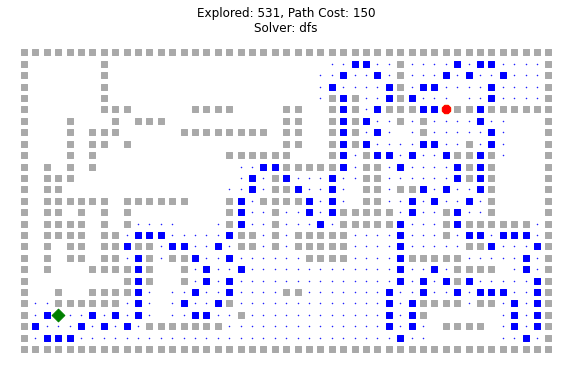

In [11]:
grid = AnimateProblem(solver='dfs', # allowed: ['astar', 'dijkstra', 'bfs', 'dfs']
                      weight=1.4,
                      height=20, width=40,
                      initial=(1, 1), goal=(35, 19),
                      obstacles=random_lines(X=range(40), Y=range(20), N=80, lengths=range(1, 7)))
grid.draw_walls()

# In case the animation is not complete,
# increase the number of frames below.
grid.run(frames=900)